In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [12]:
DIRECTORY_OUT = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data'

PATH_TO_CHEN_ADATA      = f'{DIRECTORY_OUT}/adata_c.preprocessed.NanoMnT.TumorLabeled.h5ad'
PATH_TO_CHEN_MTX_AUTHOR     = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/mtx/GSE236581_counts.mtx.gz'
PATH_TO_CHEN_FEATURE_AUTHOR = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/mtx/GSE236581_features.tsv.gz'
PATH_TO_CHEN_BARCODE_AUTHOR = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/mtx/GSE236581_barcodes.tsv.gz'

PATH_TO_CHEN_METADATA   = '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/GSE236581_CRC-ICB_metadata.txt.gz'
PATH_TO_CHEN_METADATA2  = '/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv'
PATH_TO_CHEN_METADATA3  = '/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv'
PATH_TO_CHEN_CELLTYPES = f'{DIRECTORY_OUT}/Chen_et_al.CellType_Simplified.tsv'

## Load data

In [3]:
adata_c = sc.read_h5ad(PATH_TO_CHEN_ADATA)

metadata_c  = pd.read_csv(PATH_TO_CHEN_METADATA, sep=' ')
metadata_c2 = pd.read_csv(PATH_TO_CHEN_METADATA2, sep='\t',)
metadata_c3 = pd.read_csv(PATH_TO_CHEN_METADATA3, )

dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in metadata_c3.itertuples() }
dict_PatientID_to_Response = { list(tup)[1] : list(tup)[13] for tup in metadata_c3.itertuples() }

adata_c.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_c.obs['PatientID'] ]
adata_c.obs['Response'] = [ dict_PatientID_to_Response[PID] for PID in adata_c.obs['PatientID'] ]

In [22]:
# gene expression matrix that were directly provided by the authors
mtx = sc.read_mtx(PATH_TO_CHEN_MTX_AUTHOR)
mtx = mtx.T

feature = pd.read_csv(PATH_TO_CHEN_FEATURE_AUTHOR, sep='\t', header=None)
feature.columns = ['Gene', 'Gene2', 'Feature']
feature.drop('Gene2', axis=1, inplace=True)

cell = pd.read_csv(PATH_TO_CHEN_BARCODE_AUTHOR, sep='\t', header=None)
cell.columns = ['Identifier']

mtx.var_names = feature.Gene.values
mtx.obs_names = cell.Identifier.values

dict_Identifier_to_CellInfo = { tup.Index : [tup.Ident, tup.Patient, tup.Treatment, tup.Tissue, tup.MajorCellType, tup.SubCellType] for tup in metadata_c.itertuples() }

mtx.obs['SampleIdent']      = [ dict_Identifier_to_CellInfo[idx][0] for idx in mtx.obs.index ]
mtx.obs['Patient']          = [ dict_Identifier_to_CellInfo[idx][1] for idx in mtx.obs.index ]
mtx.obs['Treatment']        = [ dict_Identifier_to_CellInfo[idx][2] for idx in mtx.obs.index ]
mtx.obs['Tissue']           = [ dict_Identifier_to_CellInfo[idx][3] for idx in mtx.obs.index ]
mtx.obs['MajorCellType']    = [ dict_Identifier_to_CellInfo[idx][4] for idx in mtx.obs.index ]
mtx.obs['SubCellType']      = [ dict_Identifier_to_CellInfo[idx][5] for idx in mtx.obs.index ]

In [4]:
mtx = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/Author.raw.h5ad')

## Compare MSI score between CR and PR patients (Fig. 4a)

In [4]:
MSI_intensity_by_Patient = list()
for PatientID, edf in adata_c.obs[(adata_c.obs['NumSTRLoci']>=10) & (adata_c.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].groupby('PatientID', observed=True):
    MSI_intensity_by_Patient.append( [PatientID, np.mean(edf['MSI_score']), edf.iloc[0].Response] )
MSI_intensity_by_Patient = pd.DataFrame(MSI_intensity_by_Patient, columns=['PatientID', 'Mean_MSI_score', 'Response'])

/tmp/ipykernel_257305/847749475.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=MSI_intensity_by_Patient,


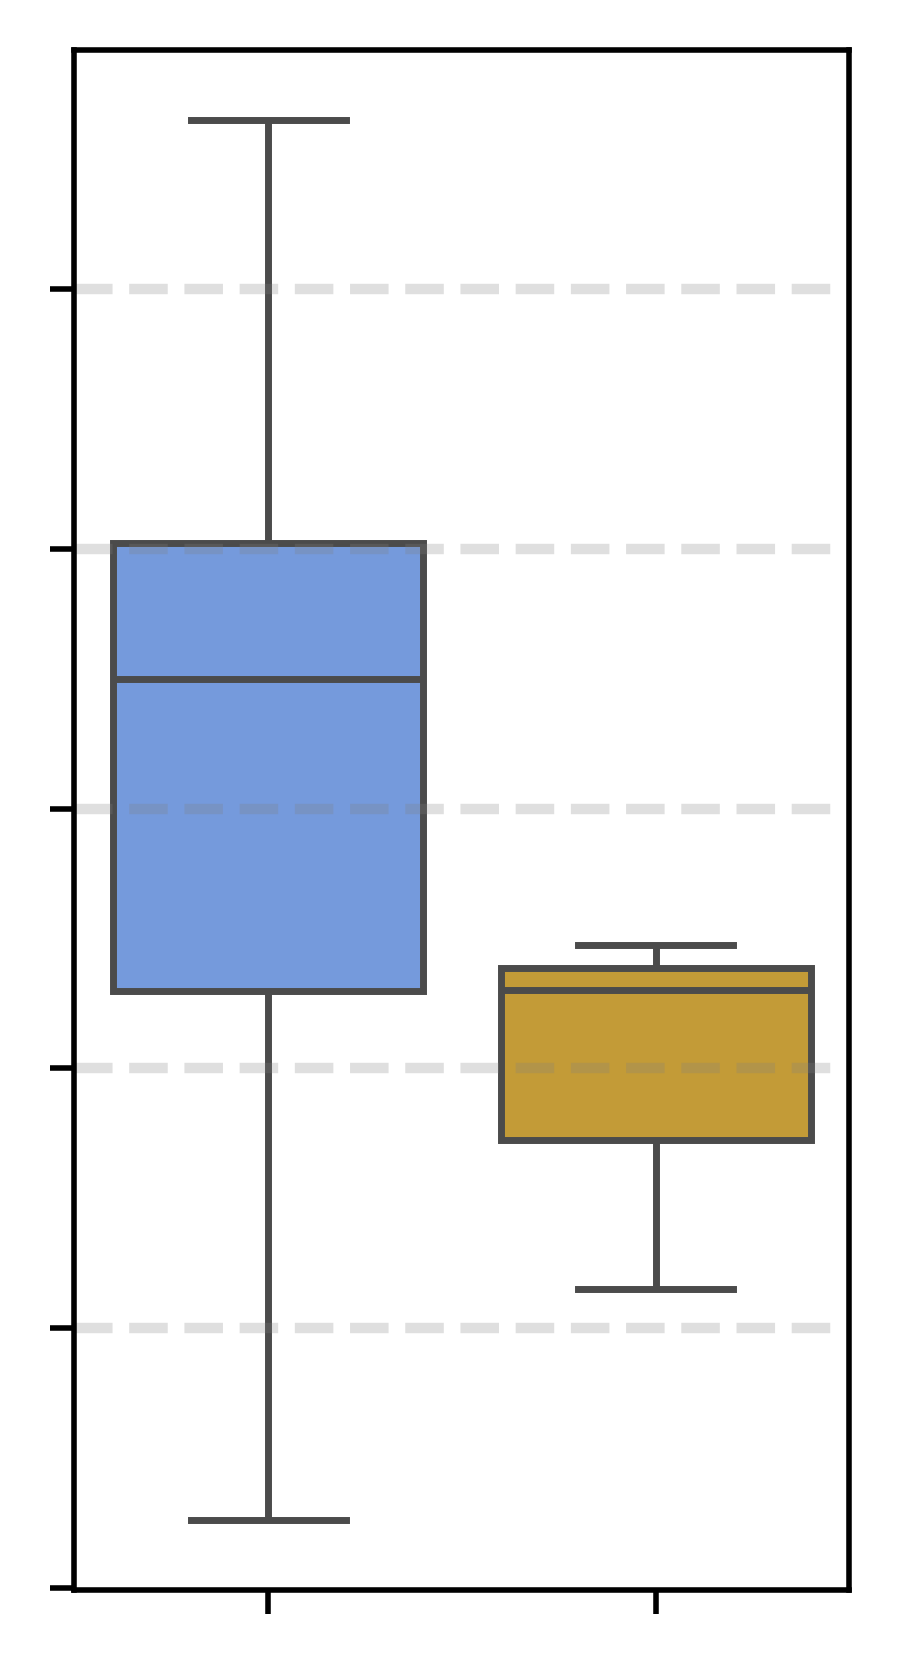

In [12]:
plt.figure(figsize=(2, 4), dpi=500)
ax = sns.boxplot(data=MSI_intensity_by_Patient, 
                 x='Response', y='Mean_MSI_score',  palette=['cornflowerblue', 'goldenrod'], 
                 whis=(0, 100))
# ax = sns.stripplot(data=STRProfileByLength2[STRProfileByLength2['isTumor']==True], x='Response', y='MSI_score', color='black',
#                    jitter=0, alpha=0.5,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
for i in [ 2, 3, 4, 5, 6 ]:
    plt.axhline( i, color='gray', ls='--', alpha=0.25, )
plt.show()


## MSI score and Tumor regression ratio (Fig. 4b)

In [7]:
MSI_intensity_by_Patient['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PatientID] for PatientID in MSI_intensity_by_Patient['PatientID'] ]

0.491 0.149
0.917 0.001


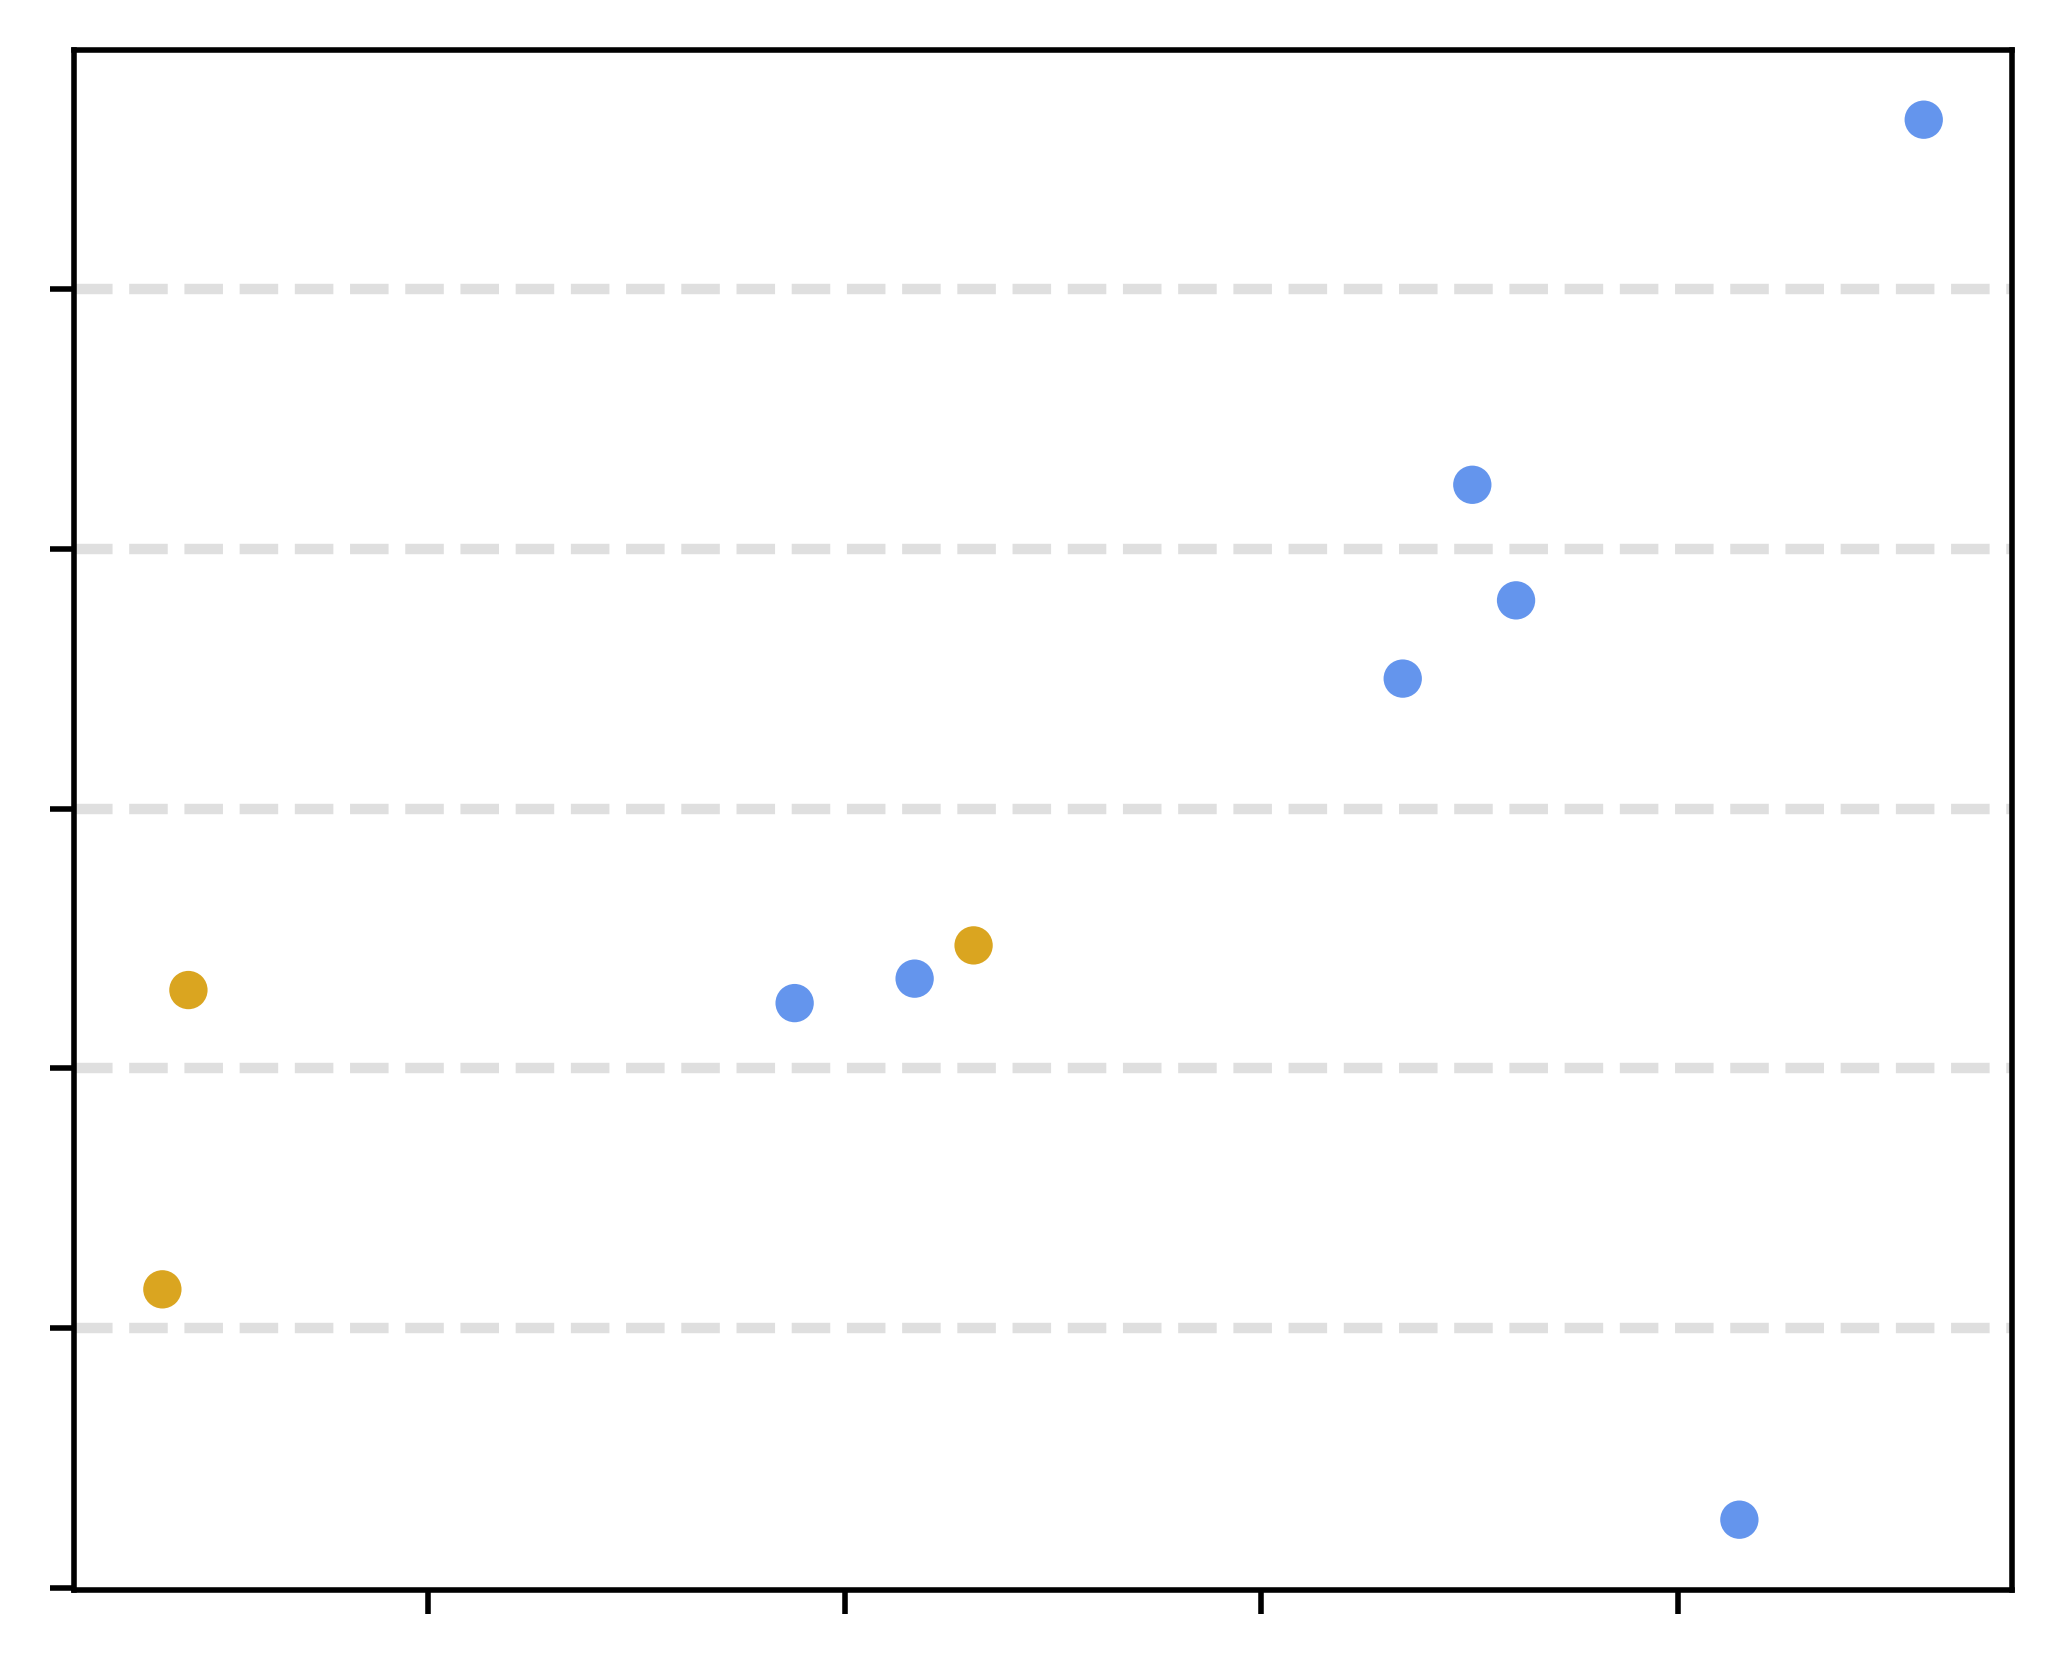

In [19]:
plt.figure(figsize=(5, 4), dpi=500)
ax = sns.scatterplot(data=MSI_intensity_by_Patient.sort_values('Mean_MSI_score'), 
                 x='TumorRegressionRatio', y='Mean_MSI_score', 
                 hue='Response', palette=['cornflowerblue', 'goldenrod'],
                 legend=None,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
for i in [ 2, 3, 4, 5, 6 ]:
    plt.axhline( i, color='gray', ls='--', alpha=0.25, )

r, pval = stats.pearsonr(MSI_intensity_by_Patient['TumorRegressionRatio'], MSI_intensity_by_Patient['Mean_MSI_score'])
print(round(r, 3), round(pval, 3))
r, pval = stats.pearsonr(MSI_intensity_by_Patient[(MSI_intensity_by_Patient['PatientID']!='P18')]['TumorRegressionRatio'], 
                         MSI_intensity_by_Patient[(MSI_intensity_by_Patient['PatientID']!='P18')]['Mean_MSI_score'])
print(round(r, 3), round(pval, 3))
plt.show()

## Temporal dynamics of Exhausted CD8+ T cells (Fig. 4c)

In [17]:
mtx = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/Author.raw.h5ad')
chen_celltypes = pd.read_csv(PATH_TO_CHEN_CELLTYPES, sep='\t')

In [20]:
dict_MajorCellType_to_CellType = { tup.Author_CellType : tup.Manual_Broad_CellType for tup in chen_celltypes.itertuples()  }
mtx.obs['CellType'] = [ dict_MajorCellType_to_CellType[SubCellType] for SubCellType in mtx.obs['SubCellType'] ]

In [ ]:
CellTypeDynamics = list()

for Patient, edf in metadata_MSI[(metadata_MSI['Tissue']=='Tumor') & (metadata_MSI['MajorCellType']!='Epi')].groupby('Patient', observed=True):
    dict_TreatmentStage_to_TotalCount = { TreatmentStage : len(edf2) for TreatmentStage, edf2 in edf.groupby('TreatmentStage', observed=True) }

    for Author_CellType_lvl_2b, edf2 in edf.groupby('Author_CellType_lvl_2b'):
        dict_TreatmentStage_to_Proportion = { TreatmentStage : len(edf3)/dict_TreatmentStage_to_TotalCount[TreatmentStage] for TreatmentStage, edf3 in edf2.groupby('TreatmentStage', observed=True) }
        for ts in {'On', 'Post', 'Pre'}:
            try: dict_TreatmentStage_to_Proportion[ts]
            except KeyError: dict_TreatmentStage_to_Proportion[ts] = 0
        
        # CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, dict_TreatmentStage_to_Proportion['Pre'], dict_TreatmentStage_to_Proportion['On'], dict_TreatmentStage_to_Proportion['Post']] )
        CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, 'Pre', dict_TreatmentStage_to_Proportion['Pre'],] )
        CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, 'On', dict_TreatmentStage_to_Proportion['On'],] )
        CellTypeDynamics.append( [Patient, Author_CellType_lvl_2b, 'Post', dict_TreatmentStage_to_Proportion['Post'],] )

try:
    CellTypeDynamics = pd.DataFrame(CellTypeDynamics, columns=['PatientID', 'CellType', 'Pre', 'On', 'Post'])
except:
    CellTypeDynamics = pd.DataFrame(CellTypeDynamics, columns=['PatientID', 'CellType', 'TreatmentStage', 'Proportion'])

CellTypeDynamics['MSI_class'] = [ dict_PatientID_to_MSI_class[PatientID] for PatientID in CellTypeDynamics['PatientID'] ]
dict_PatientID_to_Response = { tup.PatientID : tup.Response for tup in metadata2.itertuples()  }
CellTypeDynamics['Response'] = [ dict_PatientID_to_Response[PatientID] for PatientID in CellTypeDynamics['PatientID'] ]

In [13]:
mtx.raw = mtx
sc.pp.normalize_total(mtx)
sc.pp.log1p(mtx)

,Author_CellType,Manual_Broad_CellType
0,c01_CD4_Tn_CCR7,CD4+ Tn
1,c02_CD4_Tn_SELL,CD4+ Tn
2,c03_CD4_Tn_NR4A2,CD4+ Tn
3,c04_CD4_Tcm_ANXA1,CD4+ Tcm
4,c05_CD4_Tcm_GPR183,CD4+ Tcm
...,...,...
86,c87_Goblet_MUC2,Goblet
87,c88_EEC_PCSK1N,Enteroendocrine
88,c89_Tuft_PTGS1,Tuft
89,c90_Epi_MKI67,Intestinal stem
